In [1]:
# 1 - data preparation
#   1 - read the files
#   2 - manage the dataframes to create a complete one to work with
#   3 - fix missing values, create some new time, features, etc
# 2 - data analysis
#   1 - plot relation of features
#   2 - plot trends
#   3 - find if data has autocorrelation (ACF & PACF)
#   4 - regression analysis
# 3 - data transformation
#   1 - transform the data to better work with modelling
# 4 - model creation and training
# 5 - model metrics, testing, etc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from pathlib import Path
from scipy import stats
from scipy.stats import norm, skew

# import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)

pio.templates.default = 'simple_white'

In [3]:
data_dir = Path('../input/')

# load original df
train = pd.read_csv(data_dir / 'train.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category'
    },
    parse_dates=['date'],
)
test = pd.read_csv(data_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category'
    },
    parse_dates=['date'],
)
stores = pd.read_csv(data_dir / 'stores.csv',
    dtype={
        'city': 'category',
        'state': 'category',
        'type': 'category',
        'cluster': 'category',
        'store_nbr': 'category',
    }
)
oil = pd.read_csv(data_dir / 'oil.csv', parse_dates=['date'],)
transactions = pd.read_csv(data_dir / 'transactions.csv', parse_dates=['date'],
    dtype={ 'store_nbr': 'category' },
)
holidays = pd.read_csv(data_dir / 'holidays_events.csv', parse_dates=['date'],
    dtype={
        'type': 'category',
        'locale': 'category',
        'transferred': 'bool'
    },
)


In [4]:
# create a complete df with all data
# merging by date except store df which
# is merged by store_nbr
n_test = test.shape[0]
n_train = train.shape[0]
sales = train['sales']
all_df = pd.concat([train.drop('sales', axis=1), test])

all_df = all_df.merge(holidays, on='date', how='left')
# all_df = train.merge(holidays, on='date', how='left')

all_df.drop_duplicates(subset='id', inplace=True) # keep unique IDs 

all_df.rename(columns = {
    'type' : 'holiday_type',
    'locale' : 'holiday_locale',
    'locale_name': 'holiday_locale_name',
    'description': 'holiday_description',
    'transferred': 'is_holiday_transferred'
}, inplace=True)
all_df['is_holiday'] = (~all_df['holiday_type'].isna()).astype(int)
# all_df['is_holiday'] = np.where(all_df['holiday_type'].isna(), 0, 1)

all_df = all_df.merge(oil, on = 'date', how='left')
all_df.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

all_df = all_df.merge(stores, on = 'store_nbr', how='left')
all_df.rename(columns={'type': 'store_type'}, inplace=True)
all_df = all_df.merge(transactions, on = ['date', 'store_nbr'], how='left')

all_df['year'] = all_df['date'].dt.year
all_df['month'] = all_df['date'].dt.month
all_df['week'] = all_df['date'].dt.isocalendar().week
all_df['quarter'] = all_df['date'].dt.quarter
all_df['day_of_week'] = all_df['date'].dt.day_name()
all_df['day_of_month'] = all_df['date'].dt.strftime("%d").astype(int) 
all_df['day_of_year'] = all_df['date'].dt.strftime("%j").astype(int)
# all_df['is_weekend'] = all_df['day_of_week'].isin(['Saturday', 'Sunday'])
all_df['is_weekend'] = ((pd.DatetimeIndex(all_df['date']).dayofweek) // 5 == 1).astype(int)

print(f'{n_train} train samples')
print(f'{n_test} test samples')
print(f'{all_df.shape[0]} rows and {all_df.shape[1]} columns')

3000888 train samples
28512 test samples
3029400 rows and 25 columns


In [5]:
holiday_columns = [
    'holiday_type',
    'holiday_locale',
    'holiday_locale_name',
    'holiday_description',
    'is_holiday_transferred',
]
_ = [all_df[c].cat.add_categories('None', inplace=True) for c in ['holiday_type', 'holiday_locale']]
_ = [all_df[c].fillna('None', inplace=True) for c in holiday_columns]

In [6]:
all_df.sample(3)

,id,date,store_nbr,family,onpromotion,holiday_type,holiday_locale,holiday_locale_name,holiday_description,is_holiday_transferred,is_holiday,oil_price,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week,day_of_month,day_of_year,is_weekend
2707270,2707270,2017-03-04,20,HOME AND KITCHEN II,2,None,None,None,None,None,0,NaN,Quito,Pichincha,B,6,2004.0,2017,3,9,1,Saturday,4,63,1
1901754,1901754,2015-12-06,19,PRODUCE,0,Holiday,Local,Quito,Fundacion de Quito,False,1,NaN,Guaranda,Bolivar,C,15,1363.0,2015,12,49,4,Sunday,6,340,1
407245,407245,2013-08-17,35,PERSONAL CARE,0,None,None,None,None,None,0,NaN,Playas,Guayas,C,3,804.0,2013,8,33,3,Saturday,17,229,1


In [7]:
# print(f'train:{train.iloc[[0, -1]].date.values}')
# print(f'test:{test.iloc[[0, -1]].date.values}')
# print(f'transactions:{transactions.iloc[[0, -1]].date.values}')
# print(f'holiday:{holidays.iloc[[0, -1]].date.values}')
# print(f'oil price:{oil.iloc[[0, -1]].date.values}')

tmp = pd.DataFrame([
    dict(data='train', start=train.iloc[0].date, finish=train.iloc[-1].date, longer_than_test=(test.iloc[-1].date <= train.iloc[-1].date)),
    dict(data='test', start=test.iloc[0].date, finish=test.iloc[-1].date, longer_than_test='Is Test'),
    # dict(data='test', start=test.iloc[0].date, finish=test.iloc[-1].date, longer_than_test=(test.iloc[-1].date <= test.iloc[-1].date)),
    dict(data='transactions', start=transactions.iloc[0].date, finish=transactions.iloc[-1].date, longer_than_test=(test.iloc[-1].date <= transactions.iloc[-1].date)),
    dict(data='holidays', start=holidays.iloc[0].date, finish=holidays.iloc[-1].date, longer_than_test=(test.iloc[-1].date <= holidays.iloc[-1].date)),
    dict(data='oil price', start=oil.iloc[0].date, finish=oil.iloc[-1].date, longer_than_test=(test.iloc[-1].date <= oil.iloc[-1].date)),
])

fig = px.timeline(
    tmp, x_start='start', x_end='finish', y='data', title='Data timelines',
    color='longer_than_test', labels={'longer_than_test': 'last longer than test df'},
    category_orders={
        'data': ['train', 'test', 'transactions', 'holidays', 'oil price']
    },
    # hover_data=['finish'],
)
# fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig['data'][0].width = 0.2
fig['data'][1].width = 0.2
fig['data'][2].width = 0.2
fig.update_layout( # customize font and legend orientation & position
    legend=dict(
        title='Last longer than test df:', orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    ),
)

for ser in fig['data']:
    # ser['end-date']=list(set([d.strftime('%Y-%m-%d') for d in tmp['finish']]))
    # ser['hovertemplate']='category=open<br>dates=%{end-date}<br>price=%{y}<extra></extra>'
    ser['hovertemplate']='last date: %{x|%Y/%m/%d}'

fig.show()

In [8]:
tmp = oil.set_index('date').dcoilwtico.resample('D').sum().reset_index().rename(
    columns={'dcoilwtico': 'price'}
)
tmp.iloc[0,1] = tmp.iloc[1,1]
tmp['price'] = np.where(tmp['price'] == 0, np.nan, tmp['price'])
tmp['price_total'] = tmp['price'].interpolate()
tmp = tmp.melt(id_vars=['date']+list(tmp.keys()[5:]), var_name='source')
types=tmp['source'].unique()
oil_p=pd.concat([tmp.set_index('date').groupby('source')['value'].get_group(key) for key in types],axis=1)
oil_p.columns=types
oil_p.reset_index(inplace=True)
oil_p['price_interpolated'] = pd.Series()
oil_p['price_interpolated'] = oil_p[oil_p['price'].isna()]['price_total']
oil_p.head()

,date,price,price_total,price_interpolated
0,2013-01-01,93.14,93.140,NaN
1,2013-01-02,93.14,93.140,NaN
2,2013-01-03,92.97,92.970,NaN
3,2013-01-04,93.12,93.120,NaN
4,2013-01-05,NaN,93.147,93.147


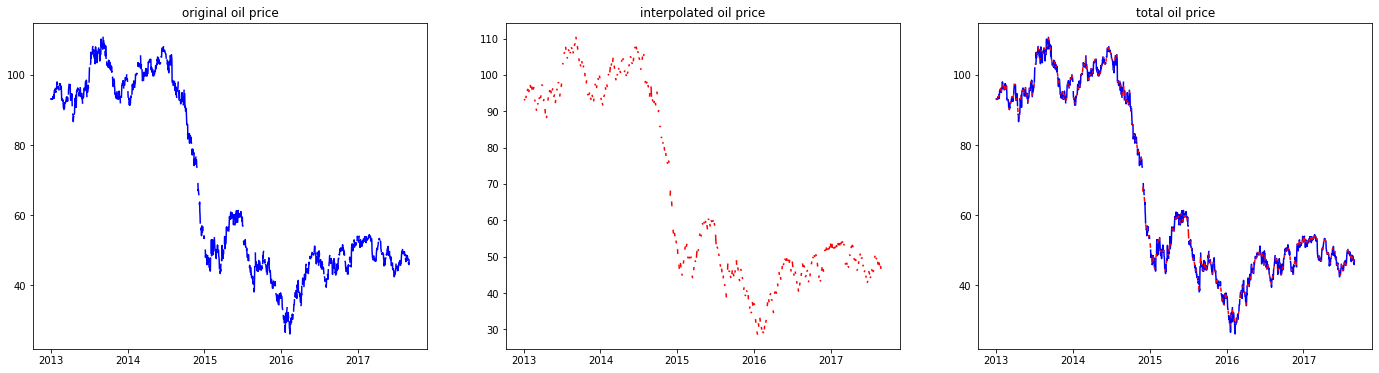

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=3,
    sharex=True,
    figsize=(24, 6)
)

ax0.set_title('original oil price')
ax0.plot(oil_p['date'],oil_p['price'], c='b')
ax1.set_title('interpolated oil price')
ax1.plot(oil_p['date'],oil_p['price_interpolated'], c='r')
ax2.set_title('total oil price')
ax2.plot(oil_p['date'],oil_p['price'], c='b')
ax2.plot(oil_p['date'],oil_p['price_interpolated'], c='r')

In [10]:
# plt.plot(p.value)
fig = px.line(
    oil_p,
    x='date',
    y=['price_total', 'price'],
    color_discrete_sequence=['red', 'blue'],
    labels={'value': 'oil price', 'variable': 'source:'},
    # labels={'price_total': 'interpolated oil price', 'p
)
newnames = {'price_total':'interpolated', 'price': 'real'}
fig.for_each_trace(
    lambda t: t.update(
        name = newnames[t.name],
            legendgroup = newnames[t.name],
            hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
    )
)
fig.update_layout(legend=dict(
    orientation='h',
    yanchor='bottom',
    y=1.02,
    xanchor='right',
    x=1,
))

In [11]:
all_df = all_df.merge(oil_p, on='date', how='left')
all_df.rename(columns={
    'oil_price': 'oil_price_real',
    'price_interpolated': 'oil_price_interp',
    'price_total': 'oil_price_total'
}, inplace=True)
all_df.drop('price', axis=1, inplace=True)
all_df.sample(2)

,id,date,store_nbr,family,onpromotion,holiday_type,holiday_locale,holiday_locale_name,holiday_description,is_holiday_transferred,is_holiday,oil_price_real,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week,day_of_month,day_of_year,is_weekend,oil_price_total,oil_price_interp
1543406,1543406,2015-05-19,14,PREPARED FOODS,0,None,None,None,None,None,0,57.30,Riobamba,Chimborazo,C,7,1351.0,2015,5,21,2,Tuesday,19,139,0,57.30,NaN
487472,487472,2013-10-01,36,PREPARED FOODS,0,None,None,None,None,None,0,102.09,Libertad,Guayas,E,10,1095.0,2013,10,40,4,Tuesday,1,274,0,102.09,NaN


In [12]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

# plt.rcParams.update({'figure.figsize': (10,10)})
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

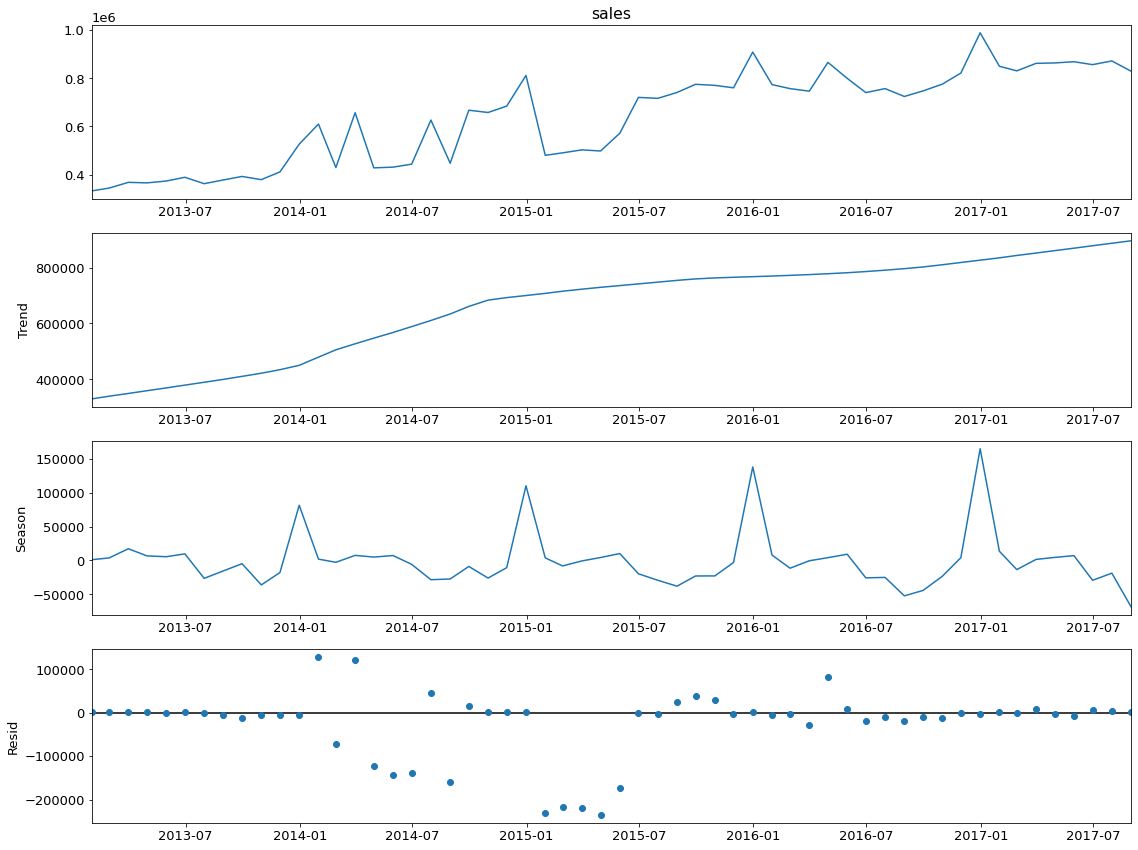

In [13]:
stl = STL(train.groupby('date')['sales'].sum().resample('M').mean(), robust=True)
res = stl.fit()
fig = res.plot()

In [14]:
result_mul = seasonal_decompose(train.groupby('date')['sales'].sum().resample('M').mean().ffill(), model='multiplicative', extrapolate_trend='freq')
result_add = seasonal_decompose(train.groupby('date')['sales'].sum().resample('M').mean().ffill(), model='additive', extrapolate_trend='freq')


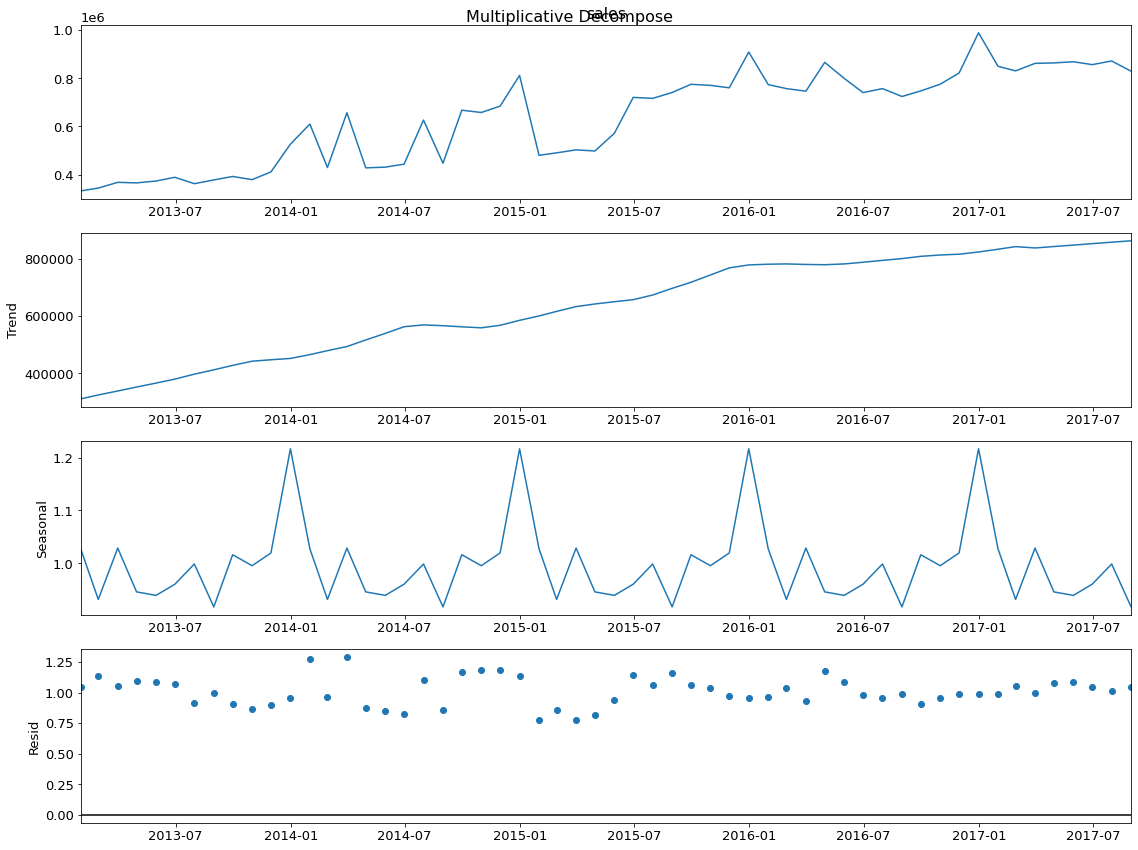

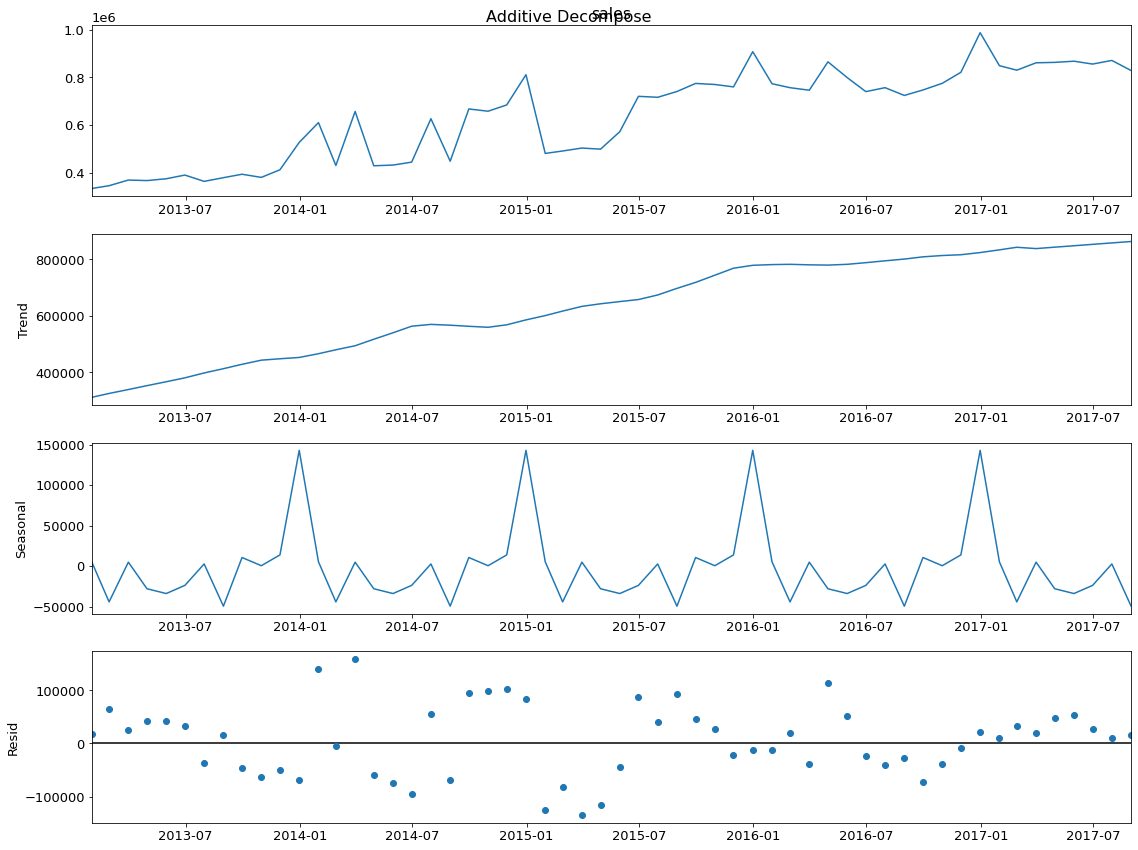

In [15]:
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=16)
result_add.plot().suptitle('Additive Decompose', fontsize=16)
plt.show()

In [16]:
all_df.head()

,id,date,store_nbr,family,onpromotion,holiday_type,holiday_locale,holiday_locale_name,holiday_description,is_holiday_transferred,is_holiday,oil_price_real,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week,day_of_month,day_of_year,is_weekend,oil_price_total,oil_price_interp
0,0,2013-01-01,1,AUTOMOTIVE,0,Holiday,National,Ecuador,Primer dia del ano,False,1,NaN,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday,1,1,0,93.14,NaN
1,1,2013-01-01,1,BABY CARE,0,Holiday,National,Ecuador,Primer dia del ano,False,1,NaN,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday,1,1,0,93.14,NaN
2,2,2013-01-01,1,BEAUTY,0,Holiday,National,Ecuador,Primer dia del ano,False,1,NaN,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday,1,1,0,93.14,NaN
3,3,2013-01-01,1,BEVERAGES,0,Holiday,National,Ecuador,Primer dia del ano,False,1,NaN,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday,1,1,0,93.14,NaN
4,4,2013-01-01,1,BOOKS,0,Holiday,National,Ecuador,Primer dia del ano,False,1,NaN,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday,1,1,0,93.14,NaN


In [36]:
from sklearn.preprocessing import LabelEncoder

all_df_dummy = pd.get_dummies(
    all_df.drop(
        [
            'holiday_type',
            'holiday_locale',
            'holiday_locale_name',
            'holiday_description',
            'is_holiday_transferred',
            'is_holiday_transferred',
            'oil_price_real',
            'state',
            'oil_price_interp',
        ],
        axis=1
    ),
    columns=[
        'family',
        'city',
        'store_type',
        'day_of_week',
    ]
)
all_df_dummy['transactions'].fillna(0, inplace=True)

all_df_dummy['date'] = all_df_dummy['date'].apply(lambda x:x.toordinal())
labelencoder = LabelEncoder()
all_df_dummy['store_nbr'] = labelencoder.fit_transform(all_df_dummy['store_nbr'])
all_df_dummy['cluster'] = labelencoder.fit_transform(all_df_dummy['cluster'])
all_df_dummy['week'] = labelencoder.fit_transform(all_df_dummy['week'])
all_df_dummy.sample(2)

,id,date,store_nbr,onpromotion,is_holiday,cluster,transactions,year,month,week,quarter,day_of_month,day_of_year,is_weekend,oil_price_total,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
117581,117581,734934,53,0,0,13,2223.0,2013,3,9,1,7,66,0,91.53,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1336122,1336122,735620,42,0,0,5,2389.0,2015,1,3,1,22,22,0,45.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [37]:
Y_train = sales.values

train_dummies = all_df_dummy[:n_train]
test_dummies = all_df_dummy[n_train:]

print(f'train shape: {train_dummies.shape}')
print(f'test shape: {test_dummies.shape}')
print(f'Y_train shape: {Y_train.shape}')

train shape: (3000888, 82)
test shape: (28512, 82)
Y_train shape: (3000888,)


In [38]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    train_dummies, Y_train, test_size=0.10, random_state=42
)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (2700799, 82)
X_test: (300089, 82)
y_train: (2700799,)
y_test: (300089,)


In [40]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
param = {
    'colsample_bytree': 0.2, 
    'max_depth': 4,  
    # 'objective': 'multi:softprob',  
    'gamma': 0.0,
    'learning_rate': 0.01,
    'min_child_weight': 1.5,
    'n_estimators': 7200,
    'reg_alpha': 0.9,
    'reg_lambda': 0.6,
    'subsample': 0.2,
    'seed': 42,
    # 'silent': 1,
} 

regr = xgb.XGBRegressor(
    **param
)

regr.fit(X_train, y_train)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(X_test)
print(f'XGBoost score on training set: {rmse(y_test, y_pred)}')

In [ ]:
model_xgb.fit(train_dummies.values, Y_train)

In [ ]:
y_pred = model_xgb.predict(X_test)
print(f'XGBoost score on training set: {rmse(y_test, y_pred)}')

In [ ]:
# Run prediction on the Kaggle test set.
y_pred_xgb = model_xgb.predict(test_dummies)
xgb_pred = np.expm1(y_pred_xgb)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv',index=False)